In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Code is taken from the [Tensorflow tutorial on Autoencoders](https://www.tensorflow.org/tutorials/generative/autoencoder). 

We want to improve the performance of the autoencoder by testing the following approaches.
1. Varying the number of layers and units in the layers
2. Employing regularization
3. Corrupting the inputs with some noise

In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [3]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [4]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

In [5]:
print (x_train.shape)
print (x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


### Display how the basic Autoencoder Performs.

Epoch 1/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0235 - val_loss: 0.0133
Epoch 2/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0115 - val_loss: 0.0105
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0100 - val_loss: 0.0097
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0094 - val_loss: 0.0093
Epoch 5/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0091 - val_loss: 0.0092
Epoch 6/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0090 - val_loss: 0.0090
Epoch 7/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0089 - val_loss: 0.0089
Epoch 8/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0088 - val_loss: 0.0089
Epoch 9/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0087 - val_loss: 0.0088
Epoch 10/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.008

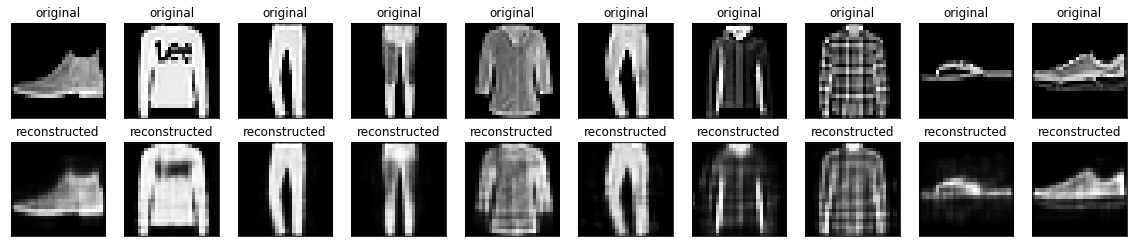

In [6]:
latent_dim = 64 

class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim   
        self.encoder = tf.keras.Sequential([layers.Flatten(),
                                            layers.Dense(latent_dim, activation='relu')])
        self.decoder = tf.keras.Sequential([layers.Dense(784, activation='sigmoid'),
                                            layers.Reshape((28, 28))])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
autoencoder = Autoencoder(latent_dim)
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

autoencoder.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test, x_test))

print(autoencoder.summary())

encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Varying hidden units and layers

Epoch 1/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0204 - val_loss: 0.0136
Epoch 2/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0117 - val_loss: 0.0105
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0098 - val_loss: 0.0092
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0087 - val_loss: 0.0084
Epoch 5/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0080 - val_loss: 0.0082
Epoch 6/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0076 - val_loss: 0.0078
Epoch 7/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0072 - val_loss: 0.0073
Epoch 8/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0069 - val_loss: 0.0071
Epoch 9/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0066 - val_loss: 0.0069
Epoch 10/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.006

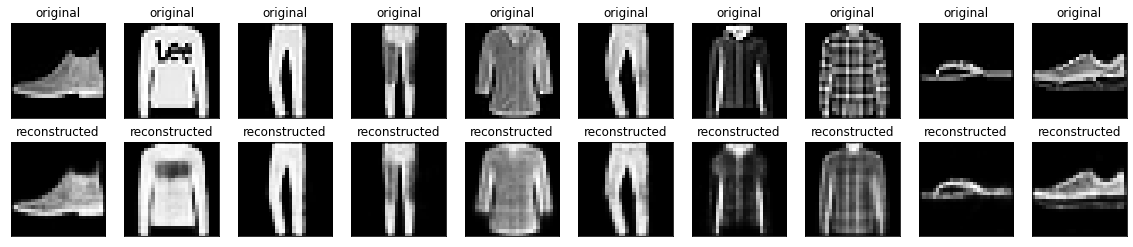

In [7]:
# 3 hidden layers and 128 units
latent_dim = 128

class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = tf.keras.Sequential([layers.Flatten(), 
                                            layers.Dense(784, activation='relu'),
                                            layers.Dense(1024, activation='relu'), 
                                            layers.Dense(latent_dim, activation='relu')])
        self.decoder = tf.keras.Sequential([layers.Dense(1024, activation='sigmoid'),
                                            layers.Dense(784, activation='sigmoid'),
                                            layers.Reshape((28, 28))])
                                           
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
autoencoder = Autoencoder(latent_dim)

autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

autoencoder.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test, x_test))

print(autoencoder.summary())
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

We see that both the training loss and the cross validation loss is reduced.
So we further increase the number of hidden layers and the number of units.

Epoch 1/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0456 - val_loss: 0.0311
Epoch 2/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0277 - val_loss: 0.0259
Epoch 3/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0242 - val_loss: 0.0231
Epoch 4/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0222 - val_loss: 0.0215
Epoch 5/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0208 - val_loss: 0.0205
Epoch 6/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0199 - val_loss: 0.0199
Epoch 7/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0193 - val_loss: 0.0191
Epoch 8/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0188 - val_loss: 0.0187
Epoch 9/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0183 - val_loss: 0.0185
Epoch 10/10
1875/1875 [==============================] - 10s 5ms/step - l

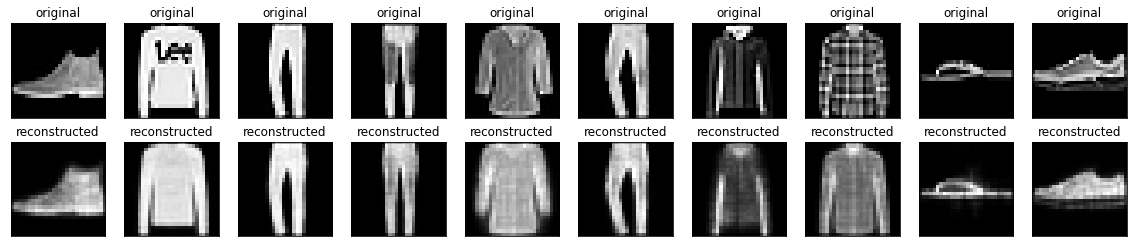

In [8]:
# 5 hidden layers and 256 units
latent_dim = 256

class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = tf.keras.Sequential([layers.Flatten(), 
                                            layers.Dense(784, activation='relu'),
                                            layers.Dense(1024, activation='relu'),
                                            layers.Dense(2048, activation='relu'),
                                            layers.Dense(4096, activation='relu'),
                                            layers.Dense(latent_dim, activation='relu')])
        self.decoder = tf.keras.Sequential([layers.Dense(1024, activation='sigmoid'),
                                            layers.Dense(4096, activation='sigmoid'),
                                            layers.Dense(2048, activation='sigmoid'),
                                            layers.Dense(784, activation='sigmoid'),
                                            layers.Reshape((28, 28))])
                                           
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
autoencoder = Autoencoder(latent_dim)

autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

autoencoder.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test, x_test))

print(autoencoder.summary())
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Now we see that the training and cross validation loss have increased. So we understand that we cannot proceed further with increasing the encoder and decoder complexity.

A reasonable number of hidden layers and hidden units would be the second choice.

### Employing regularization

We take the model which performed best in the previous step and apply regularization and see how our model performs.

Epoch 1/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0975 - val_loss: 0.0629
Epoch 2/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0583 - val_loss: 0.0553
Epoch 3/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0532 - val_loss: 0.0507
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0494 - val_loss: 0.0485
Epoch 5/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0474 - val_loss: 0.0471
Epoch 6/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0461 - val_loss: 0.0459
Epoch 7/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0452 - val_loss: 0.0449
Epoch 8/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0444 - val_loss: 0.0442
Epoch 9/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0438 - val_loss: 0.0436
Epoch 10/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.043

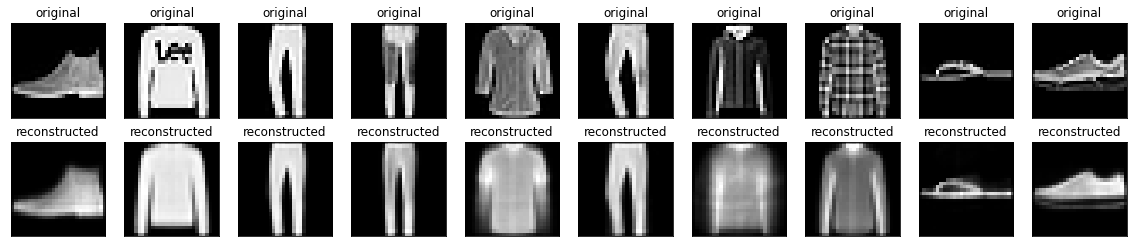

In [9]:
from tensorflow.keras import regularizers

# 3 hidden layers and 128 units
latent_dim = 128

class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = tf.keras.Sequential([layers.Flatten(), 
                                            layers.Dense(784, activation='relu', activity_regularizer=regularizers.l1(10e-5)),
                                            layers.Dense(1024, activation='relu', activity_regularizer=regularizers.l1(10e-5)), 
                                            layers.Dense(latent_dim, activation='relu', activity_regularizer=regularizers.l1(10e-5))])
        self.decoder = tf.keras.Sequential([layers.Dense(1024, activation='sigmoid',activity_regularizer=regularizers.l1(10e-5)),
                                            layers.Dense(784, activation='sigmoid', activity_regularizer=regularizers.l1(10e-5)),
                                            layers.Reshape((28, 28))])
                                           
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
autoencoder = Autoencoder(latent_dim)

autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

autoencoder.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test, x_test))

print(autoencoder.summary())
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


We see that the model is still performing worse than our best performing model, but maybe after regularization our model becomes too simple to fit the data well, so we use the more complex model which we found to be a worse fit than this model and apply regularization.

Epoch 1/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.1602 - val_loss: 0.1180
Epoch 2/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.1158 - val_loss: 0.1136
Epoch 3/10
1875/1875 [==============================] - 10s 6ms/step - loss: 0.1120 - val_loss: 0.1103
Epoch 4/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.1103 - val_loss: 0.1097
Epoch 5/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.1099 - val_loss: 0.1094
Epoch 6/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.1096 - val_loss: 0.1092
Epoch 7/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.1094 - val_loss: 0.1090
Epoch 8/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.1092 - val_loss: 0.1089
Epoch 9/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.1091 - val_loss: 0.1088
Epoch 10/10
1875/1875 [==============================] - 10s 5ms/step - l

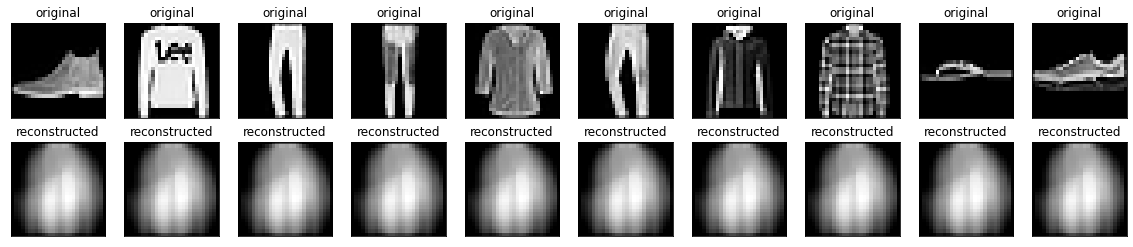

In [10]:
from tensorflow.keras import regularizers

# 5 hidden layers and 256 units
latent_dim = 256

class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = tf.keras.Sequential([layers.Flatten(), 
                                            layers.Dense(784, activation='relu', activity_regularizer=regularizers.l1(10e-5)),
                                            layers.Dense(1024, activation='relu', activity_regularizer=regularizers.l1(10e-5)),
                                            layers.Dense(2048, activation='relu', activity_regularizer=regularizers.l1(10e-5)),
                                            layers.Dense(4096, activation='relu', activity_regularizer=regularizers.l1(10e-5)),
                                            layers.Dense(latent_dim, activation='relu', activity_regularizer=regularizers.l1(10e-5))])
        self.decoder = tf.keras.Sequential([layers.Dense(4096, activation='sigmoid', activity_regularizer=regularizers.l1(10e-5)),
                                            layers.Dense(2048, activation='sigmoid', activity_regularizer=regularizers.l1(10e-5)),
                                            layers.Dense(1024, activation='sigmoid', activity_regularizer=regularizers.l1(10e-5)),
                                            layers.Dense(784, activation='sigmoid', activity_regularizer=regularizers.l1(10e-5)),
                                            layers.Reshape((28, 28))])
                                           
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
autoencoder = Autoencoder(latent_dim)

autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

autoencoder.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test, x_test))

print(autoencoder.summary())
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Even this model doesn't perform well, let us try to us a very complex model and apply regularization.

Epoch 1/10
1875/1875 [==============================] - 31s 16ms/step - loss: 0.2481 - val_loss: 0.1452
Epoch 2/10
1875/1875 [==============================] - 29s 16ms/step - loss: 0.1312 - val_loss: 0.1216
Epoch 3/10
1875/1875 [==============================] - 29s 16ms/step - loss: 0.1177 - val_loss: 0.1144
Epoch 4/10
1875/1875 [==============================] - 29s 16ms/step - loss: 0.1132 - val_loss: 0.1117
Epoch 5/10
1875/1875 [==============================] - 30s 16ms/step - loss: 0.1114 - val_loss: 0.1106
Epoch 6/10
1875/1875 [==============================] - 29s 15ms/step - loss: 0.1106 - val_loss: 0.1100
Epoch 7/10
1875/1875 [==============================] - 29s 16ms/step - loss: 0.1101 - val_loss: 0.1096
Epoch 8/10
1875/1875 [==============================] - 29s 16ms/step - loss: 0.1098 - val_loss: 0.1094
Epoch 9/10
1875/1875 [==============================] - 30s 16ms/step - loss: 0.1096 - val_loss: 0.1092
Epoch 10/10
1875/1875 [==============================] - 29s 16m

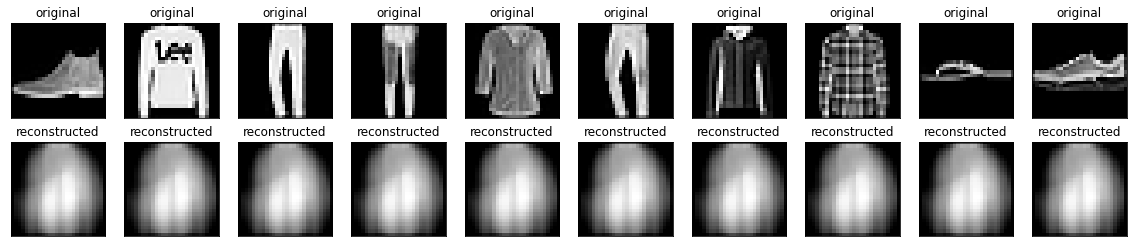

In [11]:
from tensorflow.keras import regularizers

# 7 hidden layers and 128 units
latent_dim = 128 # We do not increase the size of the hidden unit as the model might learn identity mapping.

class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = tf.keras.Sequential([layers.Flatten(), 
                                            layers.Dense(784, activation='relu', activity_regularizer=regularizers.l1(10e-5)),
                                            layers.Dense(1024, activation='relu', activity_regularizer=regularizers.l1(10e-5)),
                                            layers.Dense(2048, activation='relu', activity_regularizer=regularizers.l1(10e-5)),
                                            layers.Dense(4096, activation='relu', activity_regularizer=regularizers.l1(10e-5)),
                                            layers.Dense(4096, activation='relu', activity_regularizer=regularizers.l1(10e-5)),
                                            layers.Dense(8192, activation='relu', activity_regularizer=regularizers.l1(10e-5)),
                                            layers.Dense(latent_dim, activation='relu', activity_regularizer=regularizers.l1(10e-5))])
        self.decoder = tf.keras.Sequential([layers.Dense(8192, activation='sigmoid', activity_regularizer=regularizers.l1(10e-5)),
                                            layers.Dense(4096, activation='relu', activity_regularizer=regularizers.l1(10e-5)),
                                            layers.Dense(4096, activation='relu', activity_regularizer=regularizers.l1(10e-5)),
                                            layers.Dense(2048, activation='sigmoid', activity_regularizer=regularizers.l1(10e-5)),
                                            layers.Dense(1024, activation='sigmoid', activity_regularizer=regularizers.l1(10e-5)),
                                            layers.Dense(784, activation='sigmoid', activity_regularizer=regularizers.l1(10e-5)),
                                            layers.Reshape((28, 28))])
                                           
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
autoencoder = Autoencoder(latent_dim)

autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

autoencoder.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test, x_test))

print(autoencoder.summary())
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

All of this does not show any appreciable decrease in loss for either the training set or the test set, which means that employing regularization isn't much help here.

### Corrupting the inputs with some noise

Epoch 1/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0347 - val_loss: 0.0296
Epoch 2/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0269 - val_loss: 0.0268
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0244 - val_loss: 0.0263
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0228 - val_loss: 0.0255
Epoch 5/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0217 - val_loss: 0.0256
Epoch 6/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0208 - val_loss: 0.0253
Epoch 7/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0201 - val_loss: 0.0252
Epoch 8/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0196 - val_loss: 0.0253
Epoch 9/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0191 - val_loss: 0.0253
Epoch 10/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.018

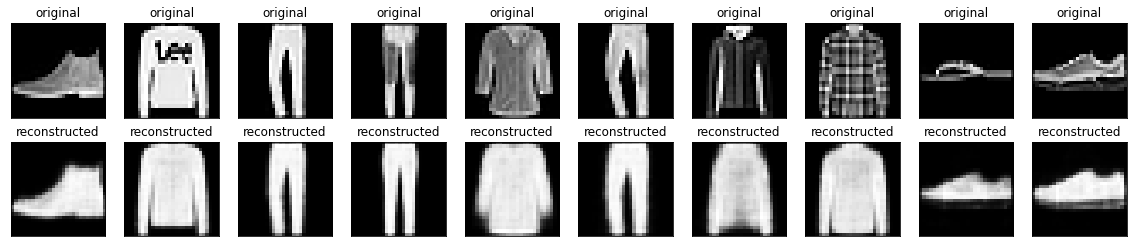

In [12]:
# Add noise to train set.
noise_train = np.reshape(np.random.normal(0,1, 60000*28*28), (60000, 28, 28))
noise_test = np.reshape(np.random.normal(0,1, 10000*28*28), (10000, 28, 28))
x_train_noisy = x_train + noise_train
x_test_noisy = x_test + noise_test

# We will use the model which has performed best up until now.
# 3 hidden layers and 128 units
latent_dim = 1000

class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = tf.keras.Sequential([layers.Flatten(), 
                                            layers.Dense(784, activation='relu'),
                                            layers.Dense(1024, activation='relu'), 
                                            layers.Dense(latent_dim, activation='relu')])
        self.decoder = tf.keras.Sequential([layers.Dense(1024, activation='sigmoid'),
                                            layers.Dense(784, activation='sigmoid'),
                                            layers.Reshape((28, 28))])
                                           
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
autoencoder = Autoencoder(latent_dim)

autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

autoencoder.fit(x_train_noisy, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

print(autoencoder.summary())
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Denoising does not provide significant improvements either. 

Therefore we assume that the best way to tune an Autoencoder is to carefully choose the architecture, since this has the most impact on the performance of the autoencoder.